<a href="https://colab.research.google.com/github/GoshKolotyan/Deep-Learning-TensorFlow2-/blob/main/11_SkimLit_NLP_Milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestonee Project 2:SkilLit

In [ ]:
#Check datatime
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-06-16 11:08:25.189660


In [ ]:
#Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-974a6504-e8ea-edae-ef4d-2bbc26ac2f80)


##Get data
Since we will be repilicate the paper above let's download the dataset they used
We can do so from the authors GitHub git clone `https://github.com/Franck-Dernoncourt/pubmed-rct.`

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.36 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

##Preprocess data

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want out data to look

```[{'line_number':0,
  'target':'Background',
  'text':Emotional eating is associated with overeating and the development of obesity,.\n'
  'the_development':11}]```
  

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data

  Takes in filename,reads it contents and sorts throught each line,
  extracting things like the target label,the text of the sentences,
  how many sentences are in the current abstract and what sentences
  number the target line is.
  """

  input_line = get_lines(filename)#got all line from filename
  abstract_lines = '' #creat an empty absttaract
  abstract_samples = [] #creat an empty list abstracts

  #Loop through each line in the target file
  for line in input_line:
    if line.startswith("###"):#Check to see if the is an ID line
      abstract_id = line
      abstract_lines = ""#reset the abstarct string if the line is an ID line
    elif line.isspace():#Check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()#split abstarct into separatc

      #Iterate through each line in single abstract and count them at the same time
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data = {}# creat an empty dict
        target_text_split = abstract_line.split("\t")# split target label from text
        line_data['target'] = target_text_split[0]#get target label
        line_data['text'] = target_text_split[1].lower()#get target text and lower it
        line_data['line_numer'] = abstract_line_number#what number line does the line appear in the abstract
        line_data['total_line'] = len(abstract_line_split)-1 #how many total lines are there in the target abstract?(start from 0)
        abstract_samples.append(line_data)# add line data to abstract samples list
    else:#if the above conditions are not fulfilled the line contains labelled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
#Get data from files and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

CPU times: user 584 ms, sys: 105 ms, total: 689 ms
Wall time: 848 ms


In [ ]:
len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [ ]:
#Check results
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_numer': 0,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_numer': 1,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_numer': 2,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_numer': 3,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontario and mc

Noww are data is format of dict now visualize it

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

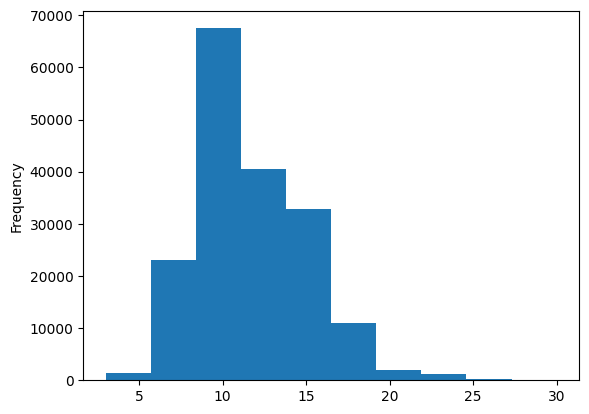

In [ ]:
#let's check the lenght of different line
train_df.total_line.plot.hist()

###Get lists of sentences

In [ ]:
#Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [ ]:
#View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels(Ml models require numeric labels)

In [ ]:
#One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
#Check what one hot encoder look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

###Label encode labels

In [ ]:
#Extract labels("target" columns) and encode them into int
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

In [ ]:
#Get class names and number of classes from LabelsEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Starting a series of modelling experiments...

As usual , we are going to be trying out a bunch of different models and seeing which one works best.

And as always, we are going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier)

##Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Creat a pipeline
model_0 = Pipeline([
    ('tf-idf',TfidfVectorizer()),
    ('clf',MultinomialNB())
])

#Fit the pipeline to the training data
model_0.fit(X=train_sentences,
           y=train_labels_encoded,)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,y=val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

###Download helper functions script
In the previous module, we wrote to compare preditions mertics(accuracy,precision,recall & f-1) and rather than rewrite it here,let's download it our helper functions script:

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-16 11:09:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-16 11:09:04 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
baseline_results = calculate_results(val_labels_encoded,baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

###Model 1:Conv1D

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
#How long is each sentences on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len  = np.mean(sent_lens)
avg_sent_len

26.338269273494777

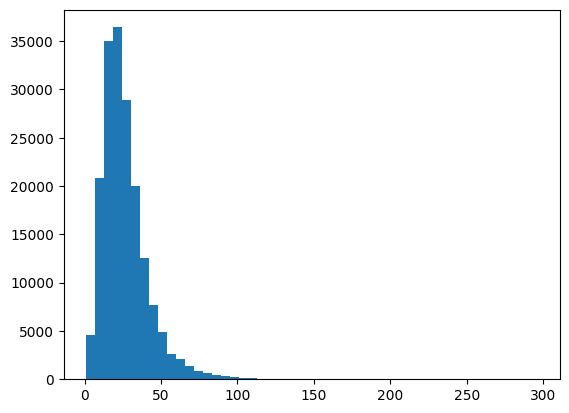

In [ ]:
#What the ditribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=50);

In [ ]:
#How long of a sentences lenght cover 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
#Maxi sequence len in the train set
max(sent_lens)

296

### Creat text vectorizer layer

We want to make a layer which maps our text from words to number

In [ ]:
#How many words are in our vocabulary
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers import TextVectorization
#Creat text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens, #how mnay words in the vocabulary
                                    output_sequence_length=output_seq_len,#how long do you whant tou sequnense to be
                                    )

In [ ]:
#Adapt text vectorizer train sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
#test out Text Vectorizer
import random
target_sentences = random.choice(train_sentences)
print(f"Text:\n {target_sentences}")
print(f"\nLength of text: {len(target_sentences)}")
print(f"\nVectorized text {text_vectorizer([target_sentences])}")

Text:
 physical activity was assessed with a pedometer and the international physical activity questionnaire ( ipaq ) , hrqol was evaluated with the short form-@ ( sf-@ ) .

Length of text: 165

Vectorized text [[  189   190    10   113     7     8  5414     3     2   848   189   190
    325 20368  1003    10   184     7     2   654   920  1233     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
#Get the unique words in the vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()#get all of the unique words in our training data
top_5_words = rct_20k_text_vocab[:5] #Get the most common words
bottom_5_words = rct_20k_text_vocab[-5:]#Get the least common words
print(f"Number in words in vocab: {len(rct_20k_text_vocab)}")
print(f"5 most common words: {rct_20k_text_vocab[:5]}")
print(f"5 least common words: {rct_20k_text_vocab[-5:]}")

Number in words in vocab: 64841
5 most common words: ['', '[UNK]', 'the', 'and', 'of']
5 least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
#Get config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

###Creat embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding
token_embed = Embedding(input_dim=len(rct_20k_text_vocab),
                        output_dim=128,
                        mask_zero=True,
                        name='token_embedding')

In [ ]:
#show example of embedding
print(f"Sentense before vectorization:\n{target_sentences}\n")
vectorized_sen = text_vectorizer([target_sentences])
print(f"Sentense after vectorize(befor embedding){vectorized_sen}")
embed = token_embed(vectorized_sen)
print(f"Sentense after embedding {embed}")
print(f"Sentense after embedding shape {embed.shape}")

Sentense before vectorization:
physical activity was assessed with a pedometer and the international physical activity questionnaire ( ipaq ) , hrqol was evaluated with the short form-@ ( sf-@ ) .

Sentense after vectorize(befor embedding)[[  189   190    10   113     7     8  5414     3     2   848   189   190
    325 20368  1003    10   184     7     2   654   920  1233     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentense after embedding [[[-0.0380752  -0.00469335 -0.03568572 ... -0.0192297  -0.0302295
    0.03079983]
  [ 0.0372736   0.03568112  0.03153111 ...  0.01767793 -0.03255763
   -0.01435189]
  [ 0.03983707  0.03084883 -0.02863307 ...  0.03454826  0.04212702
    0.02314085]
  ...
  [ 0.01162766 -0.0368997   0.02911818 ... -0.01760411 -0.0189755
    0.02343371]
  [ 0.01162766 -0.0368997   0.02911818 ... -0.01760411 -0.

### Creating datasets (makeing sure our data run faster as posible)
We are going to setup our data to run fast as posible with the TF `tf.dataAPI`

In [ ]:
#Turn data into TF datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [ ]:
#Take the TensorSliceDataset and turn them into perdected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

##Model 1:Conv1D

In [ ]:
#Creat model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs)#vectrize inputs
token_embeddings = token_embed(text_vectors)#creat embedding
x = layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_1 = tf.keras.Model(inputs,outputs)
#comile model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics=['accuracy'])


In [ ]:
#model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
#Fit model
history_model_1 = model_1.fit(train_dataset,
                           steps_per_epoch = int(0.1*len(train_dataset)),
                           epochs=3,
                           validation_data = valid_dataset,
                           validation_steps = int(0.1*len(valid_dataset)))#only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 47s 64ms/step - loss: 0.9094 - accuracy: 0.6415 - val_loss: 0.6814 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6524 - accuracy: 0.7598 - val_loss: 0.6299 - val_accuracy: 0.7729
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6124 - accuracy: 0.7770 - val_loss: 0.5938 - val_accuracy: 0.7859


In [ ]:
#Make predictions
model_1_preds_probs = model_1.predict(valid_dataset)
#Convert pred probs to classes
model_1_preds = tf.argmax(model_1_preds_probs,axis=1)

945/945 [==============================] - 2s 2ms/step


In [ ]:
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)

In [ ]:
model_1_results

{'accuracy': 78.67403680656693,
 'precision': 0.7830226705687127,
 'recall': 0.7867403680656693,
 'f1': 0.7840436470393266}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

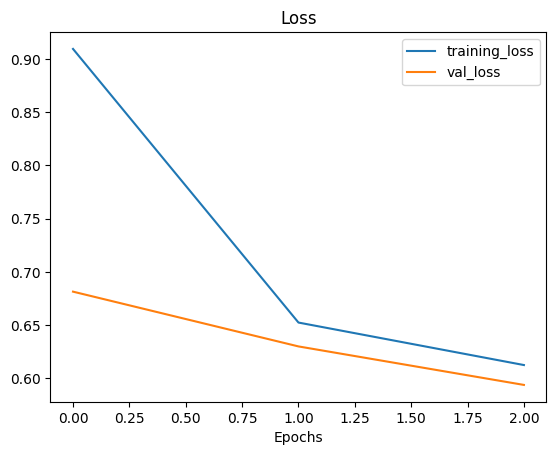

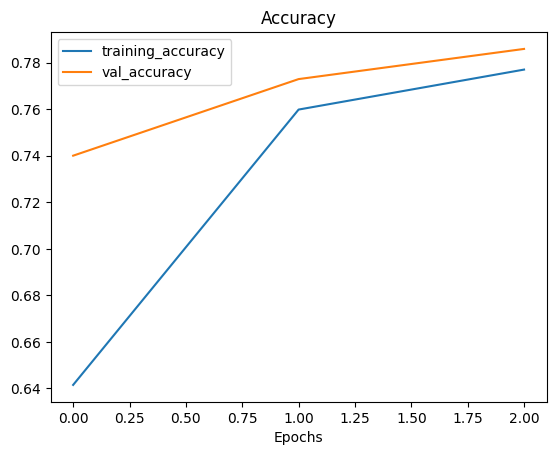

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(history_model_1)

##Model 2:Feature extraction with pretrained token embeddings

Now lets use pretrained word embedding from TensorFlow Hub, more specifically the universal sentences embedding https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
#Downloading model from TF HUb
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [ ]:
#Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\m {use_embedded_sentence}")
print(f'lenght is {len(use_embedded_sentence[0])}')

Random sentence:
 we investigated lass and bass in a dual-task paradigm with and without the possibility to cross-check alerts with raw data information .
Sentence after embedding:\m [[ 0.00572203  0.0354959  -0.07132947  0.00236595  0.03252186 -0.02689418
  -0.01513174 -0.04289804  0.07037222 -0.00130727  0.06420343 -0.00821745
   0.05118519  0.04460064 -0.06165403 -0.02623836  0.00815309 -0.0109665
   0.06700057  0.03706635  0.0627817   0.02975701 -0.02921639  0.0327629
  -0.09417871  0.01140436 -0.05974818 -0.04051965  0.01845914  0.01834962
  -0.00875604  0.01168471  0.04323692 -0.00134485 -0.07922138  0.00219058
  -0.09525184 -0.00364547 -0.00413222 -0.08303603  0.01314307  0.08000886
  -0.00307347  0.02275359  0.03197554  0.01610375 -0.02492875  0.00357946
  -0.01397164  0.06567596  0.0119198  -0.06666077 -0.00104903  0.01291913
  -0.02103277 -0.00601841  0.01457577 -0.00211244 -0.02971099 -0.0839927
  -0.06148666 -0.00212714  0.01086418 -0.03340168 -0.07215393  0.02778231
  -0.0

In [ ]:
#Creating model
inputs = layers.Input(shape=[],dtype='string')
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation='relu')(pretrained_embedding)
outputs = layers.Dense(5,activation='softmax')(x)
model_2 = tf.keras.Model(inputs,outputs)

#Compile model
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
history_model_2 = model_2.fit(train_dataset,
                             steps_per_epoch = int(0.1*len(train_dataset)),
                             epochs=3,
                             validation_data = valid_dataset,
                             validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9158 - accuracy: 0.6451 - val_loss: 0.7988 - val_accuracy: 0.6862
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7693 - accuracy: 0.7014 - val_loss: 0.7555 - val_accuracy: 0.7025
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7512 - accuracy: 0.7120 - val_loss: 0.7376 - val_accuracy: 0.7141


In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)

945/945 [==============================] - 11s 11ms/step


In [ ]:
model_2_results = calculate_results(val_labels_encoded,model_2_preds)
model_2_results

{'accuracy': 71.4153316562955,
 'precision': 0.7145166036495192,
 'recall': 0.7141533165629551,
 'f1': 0.7112074883477679}

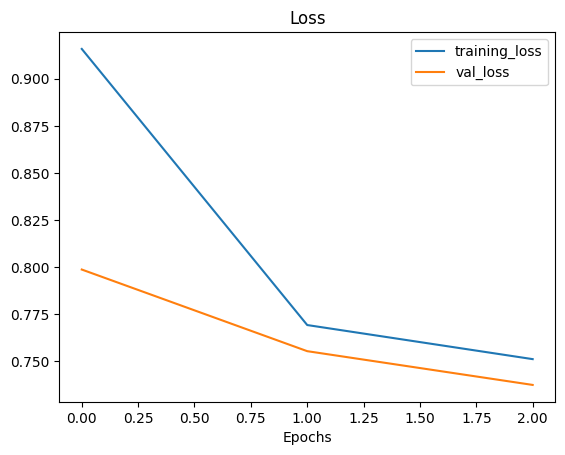

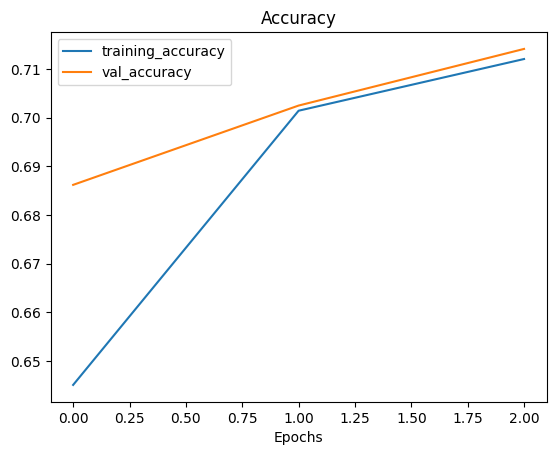

In [ ]:
plot_loss_curves(history_model_2)

## Model 3: Conv1D with character embeddings
Previosle we have token-level embeddings but we will need to do simillar steps for characters if we want to use char-level embeddings.

### Creating a character-lebel tokenizer

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_train_sentence)


'w e   i n v e s t i g a t e d   l a s s   a n d   b a s s   i n   a   d u a l - t a s k   p a r a d i g m   w i t h   a n d   w i t h o u t   t h e   p o s s i b i l i t y   t o   c r o s s - c h e c k   a l e r t s   w i t h   r a w   d a t a   i n f o r m a t i o n   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])


t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

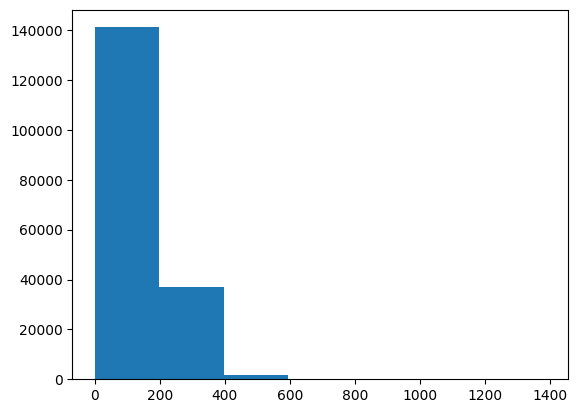

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
c l i n i c a l t r i a l . g o v   n c t @   .

Length of chars: 22

Vectorized chars:
[[11 12  4  6  4 11  5 12  3  8  4  5 12 18  7 21  6 11  3  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]

### Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
c l i n i c a l t r i a l . g o v   n c t @   .

Embedded chars (after vectorization and embedding):
[[[-4.3616474e-02 -2.9688239e-02 -5.4356568e-03 ...  2.6935007e-02
   -1.7069697e-02 -6.3031204e-03]
  [ 2.6691705e-05 -3.6097690e-04  8.4417835e-03 ...  2.5535133e-02
    4.5181248e-02  7.3885918e-03]
  [-2.0621061e-02  2.1111939e-02 -2.2501087e-02 ...  1.0074876e-02
    2.8452467e-02 -4.2711377e-02]
  ...
  [-4.4316661e-02 -3.2670915e-02 -1.5475310e-02 ...  9.2195161e-03
   -6.5829158e-03  2.3334373e-02]
  [-4.4316661e-02 -3.2670915e-02 -1.5475310e-02 ...  9.2195161e-03
   -6.5829158e-03  2.3334373e-02]
  [-4.4316661e-02 -3.2670915e-02 -1.5475310e-02 ...  9.2195161e-03
   -6.5829158e-03  2.3334373e-02]]]

Character embedding shape: (1, 290, 25)


In [ ]:
#Creating model 3
inputs = layers.Input(shape=[],dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5,activation='softmax')(x)
model_3 = tf.keras.Model(inputs,outputs,name='Model_3_conv1D_char_embedding')

#compile model
model_3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "Model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.4626 - accuracy: 0.3411 - val_loss: 1.4126 - val_accuracy: 0.4006
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.3663 - accuracy: 0.4236 - val_loss: 1.3330 - val_accuracy: 0.4438
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 1.3262 - accuracy: 0.4500 - val_loss: 1.3169 - val_accuracy: 0.4438


In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 1.3157 - accuracy: 0.4475


[1.3157209157943726, 0.4474712014198303]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.17326164, 0.24715148, 0.25531203, 0.15924847, 0.16502644],
       [0.11531933, 0.16198674, 0.18099596, 0.06765096, 0.47404706],
       [0.10214654, 0.17054453, 0.37912226, 0.10603815, 0.24214849],
       ...,
       [0.05642284, 0.09781142, 0.20415232, 0.04292237, 0.5986911 ],
       [0.04015357, 0.0910435 , 0.1736993 , 0.04734664, 0.647757  ],
       [0.13971588, 0.16844304, 0.20550115, 0.06729436, 0.41904554]],
      dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 4])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.74712034952999,
 'precision': 0.377354817531867,
 'recall': 0.4474712034952999,
 'f1': 0.39274288337341695}

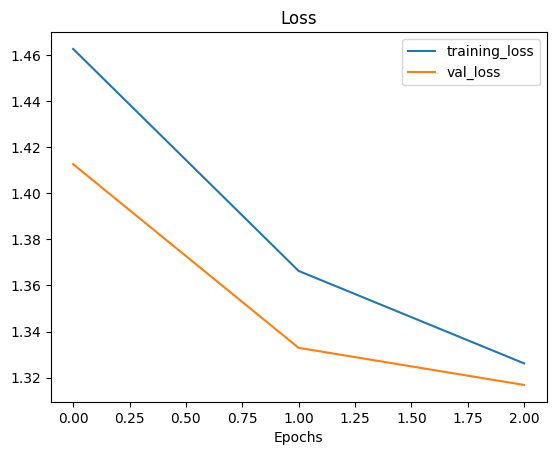

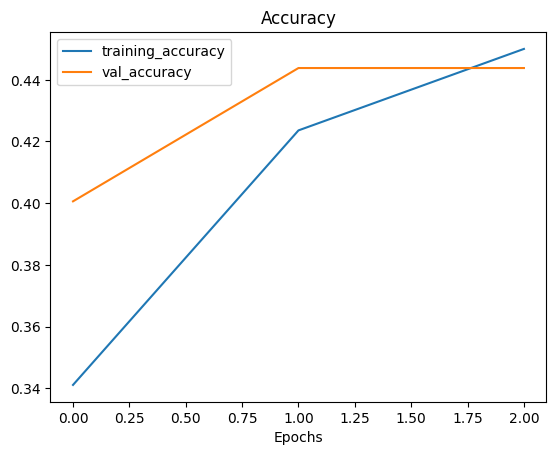

In [ ]:
plot_loss_curves(history_model_3)

##Model 4: Combine pretrained token embedding + charset embedding

1. Creat a token-level embedding model(similar `model_1`)
2. Creat a charcter-level model (simialr to `model_3`)
3. Combine 1 and 2 withe concatenate this is from `layers.Concatenate`
4. Build a series of outputs on top of 3 similar to Figure 1 and section 4.2 of paper
5. Construct a model which takes token and character-level sequences as input and produces label probabilities as output

In [ ]:
# 1.Setup tokeninputs/model
token_inputs = layers.Input(shape=[],dtype=tf.string,name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs = token_outputs)
# 2.Setup chat inputs/model
char_inputs = layers.Input(shape=(1,),dtype='string',name='char_inpurt')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)#bi-LSTM shown in Figure 1 of paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)
# 3.Concatinate token and char inputs (creat hybrid)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])
# 4.Creat output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation='softmax')(final_dropout)
# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.inputs,char_model.inputs],
                         outputs = output_layer,
                         name='model_4_token_and_chare_embeddings')

In [ ]:
#compile model
model_4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
model_4.summary()

Model: "model_4_token_and_chare_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inpurt (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inpurt[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   

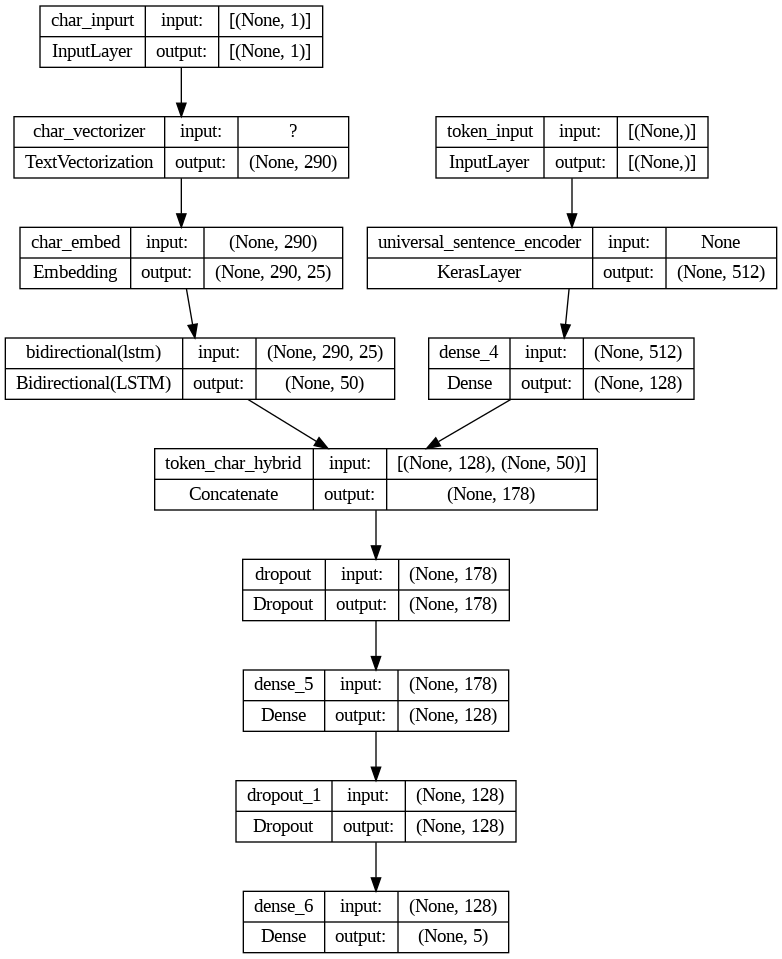

In [ ]:
#Plot hybrid and character model
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

### Combineing and token character data into `tf.data.Dataset`

In [ ]:
#Combines chars and tokens into dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

#Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Combines chars and tokens into dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

#Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Combines chars and tokens into dataset
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data,test_char_token_labels))

#Prefetch and batch train data
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Check out what we creat
train_char_token_dataset,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

###Fiting a model on token and character-level sequences

In [ ]:
#Fiting model
history_model_4 = model_4.fit(train_char_token_dataset,
                            steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                            epochs=3,
                            validation_data=val_char_token_dataset,
                            validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 38ms/step - loss: 0.9954 - accuracy: 0.6049 - val_loss: 0.7922 - val_accuracy: 0.6991
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 0.8114 - accuracy: 0.6854 - val_loss: 0.7346 - val_accuracy: 0.7231
Epoch 3/3
562/562 [==============================] - 19s 35ms/step - loss: 0.7801 - accuracy: 0.7038 - val_loss: 0.7016 - val_accuracy: 0.7377


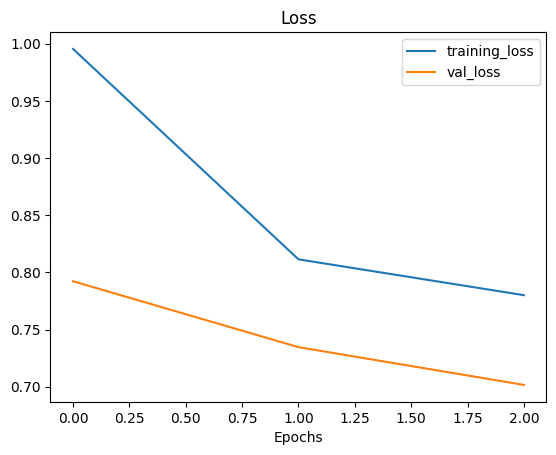

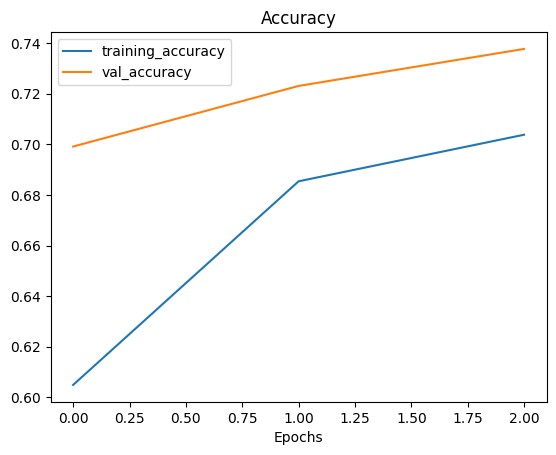

In [ ]:
#Plot curves
plot_loss_curves(history_model_4)

In [ ]:
#Evaluating one the whole valid dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.7029 - accuracy: 0.7311


[0.702898383140564, 0.7311002016067505]

In [ ]:
#Make predictions
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 18s 18ms/step


array([[4.2384762e-01, 3.6186984e-01, 4.6582506e-03, 2.0120895e-01,
        8.4153302e-03],
       [2.4224100e-01, 5.6818795e-01, 4.5909286e-03, 1.8284543e-01,
        2.1347075e-03],
       [3.4822100e-01, 1.4423154e-01, 3.6290009e-02, 4.4219202e-01,
        2.9065425e-02],
       ...,
       [3.7710267e-04, 7.7420254e-03, 3.3274185e-02, 1.3469755e-04,
        9.5847195e-01],
       [7.8230100e-03, 4.6070572e-02, 2.7066261e-01, 4.2214165e-03,
        6.7122233e-01],
       [4.2198876e-01, 4.0347192e-01, 1.1328854e-01, 2.7650110e-02,
        3.3600733e-02]], dtype=float32)

In [ ]:
#Format pred probs into pred labels
model_4_pred = tf.argmax(model_4_pred_probs,axis=1)
model_4_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [ ]:
#Get results of token-char-hybrid model
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_pred)
model_4_results

{'accuracy': 73.11002250761287,
 'precision': 0.7314225876989542,
 'recall': 0.7311002250761287,
 'f1': 0.7276229434542274}

##Model 5: Transfer learning woth pretrained token embeddings + character embeddings+positional embeddings

In [ ]:
train_df.head()

,target,text,line_numer,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


>🔑**Note:** Any engineered features used to train a model need to be available at test time.In our case, line number and total lines are available

### Creat positional embeddings

####For `df['line_numer']`

In [ ]:
#How many different line numbers are there
train_df['line_numer'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_numer, dtype: int64

<Axes: ylabel='Frequency'>

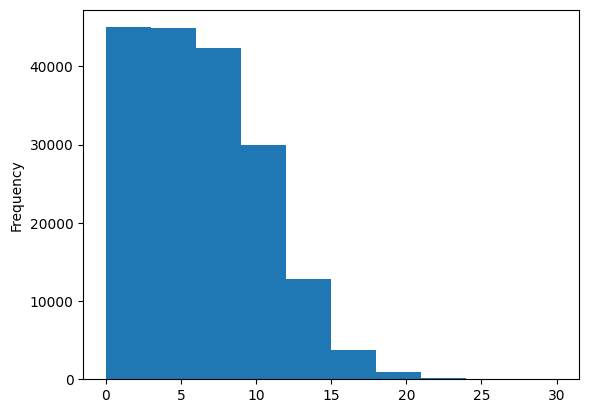

In [ ]:
 #Check the distribution of 'line_numer'
 train_df.line_numer.plot.hist()

In [ ]:
#User TF to creat one-hot encodede tensors of our 'line_numer'
train_line_numbers_one_hot = tf.one_hot(train_df['line_numer'].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_numer'].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_numer'].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

####For `df['total_line']`

In [ ]:
#How many differnet line number are
train_df['total_line'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_line, dtype: int64

<Axes: ylabel='Frequency'>

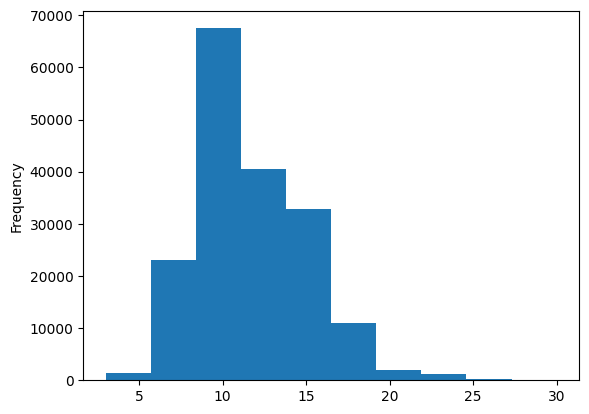

In [ ]:
#Check the distribution of total lines
train_df['total_line'].plot.hist()

In [ ]:
train_df['total_line'].dtype

dtype('int64')

In [ ]:
#Check the coverage of a 'total_line' value of 20
np.percentile(train_df.total_line,98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df['total_line'].to_numpy(),depth=20,)
val_total_lines_one_hot = tf.one_hot(val_df['total_line'].to_numpy(),depth=20,)
test_total_lines_one_hot = tf.one_hot(test_df['total_line'].to_numpy(),depth=20,)
train_total_lines_one_hot[:10],train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

###Building a triblide embedding model

1. Creat a token-level model
2. Creat a carecter-level model
3. Creat a model for the `line_numer` feature
4. Creat a model for the `total_line` feature
5. Combine the outputs of 1 and 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3,4,5 using `tf.keras.layers.Concatenate`
7. Creat an output layer to accept the tribried embedding and output label probabilities
8. Compine the inputs of 1,2,3,4 and outputs of inot a `tf.keras.Model`

In [ ]:
from keras.layers.serialization import activation
#1.Token inputs
token_inputs = layers.Input(shape=[],dtype='string',name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,outputs=token_outputs)

#2.Char inputs
char_inputs = layers.Input(shape=(1,),dtype='string',name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

#3 Creat a model for 'line model'
line_numer_inputs = layers.Input(shape=(15,),dtype=tf.float32,name='line_numer_inputs')
x = layers.Dense(32,activation='relu')(line_numer_inputs)
line_numer_model = tf.keras.Model(inputs=line_numer_inputs,
                                  outputs=x)
#4. Creat a model for total_line
total_line_inputs = layers.Input(shape=(20,),dtype=tf.float32,name='total_line_inputs')
y = layers.Dense(32,activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs,y)

#5. Combine token and char embedding s into hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                             char_model.output])
z = layers.Dense(256,activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

#6. Combine positional embedding with combined token and char embedding
tribred_embeddings =layers.Concatenate(name='char_token_positional_embedding')([line_numer_model.output,
                                                                                total_line_model.output,
                                                                                z])
#7. Creat output layer
output_layer = layers.Dense(5,activation='softmax',name='output_layer')(tribred_embeddings)

#8. Put togther model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_numer_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs = output_layer,
                         name='model_5_tribried_embedding_model')

In [ ]:
#summary
model_5.summary()

Model: "model_5_tribried_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['

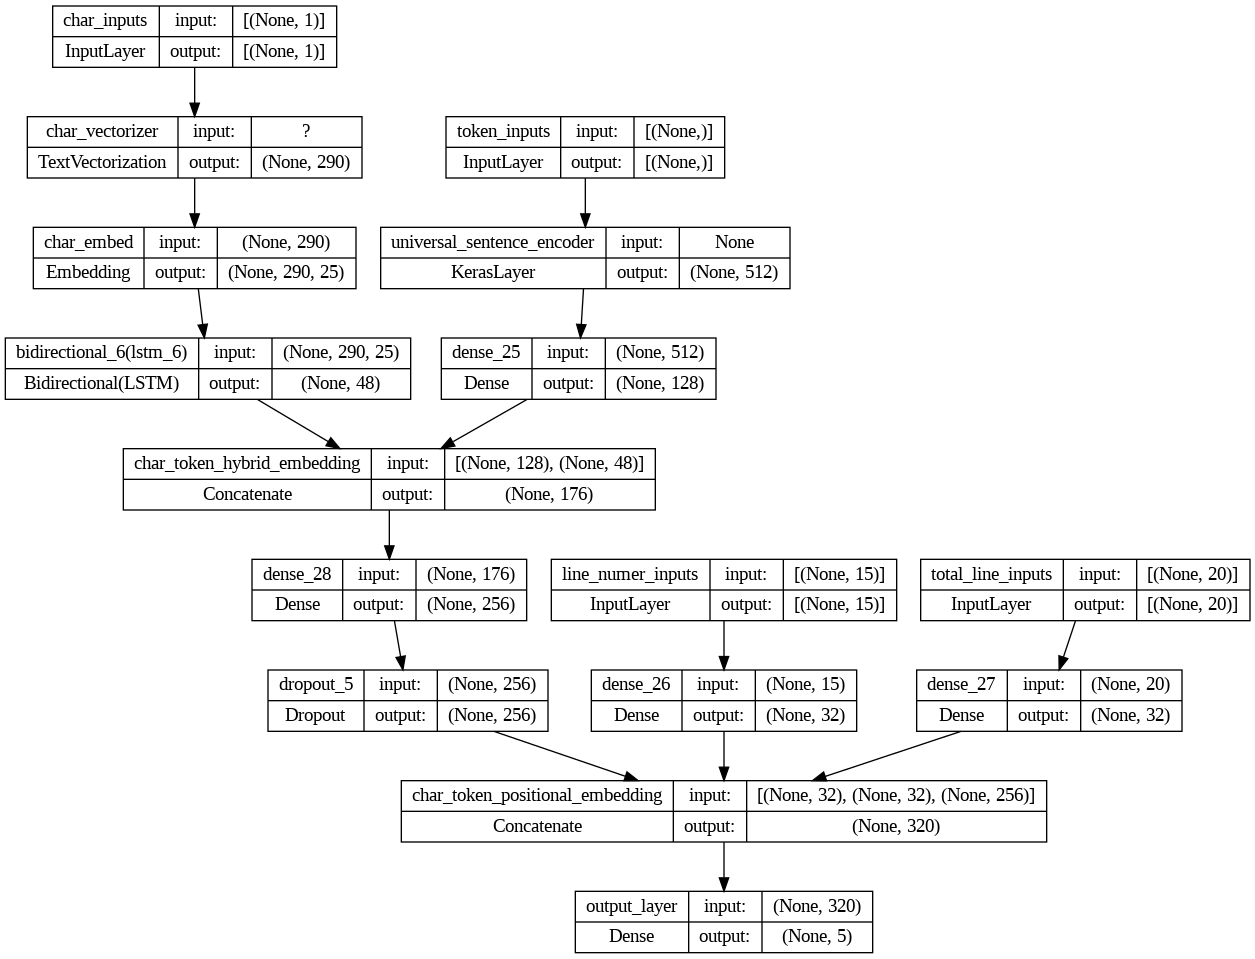

In [ ]:
#Plot hybrid and character model
from keras.utils import plot_model
plot_model(model_5,show_shapes=True)

What is label smoothing?
For example, if our model gets too confident on a single class(e.g. its prediction probabillity is realy high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0,0.0,1.0,0.0,0.0]`

what label smothing does is it assigns some of the value from the highest pred prob to other classes, in tuen, hopefully imprving generalization: `[0.01,0.01,0.96,0.01,0.01]`

In [ ]:
#compile model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),#for overfiting
                optimizer='adam',
                metrics=['accuracy'])

### Creat tribrid embedding dataset using tf.data

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
#Fit model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps = int(0.1*len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9158 - accuracy: 0.8483 - val_loss: 0.9039 - val_accuracy: 0.8504
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 0.9014 - accuracy: 0.8598 - val_loss: 0.9027 - val_accuracy: 0.8547
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9001 - accuracy: 0.8586 - val_loss: 0.9090 - val_accuracy: 0.8491


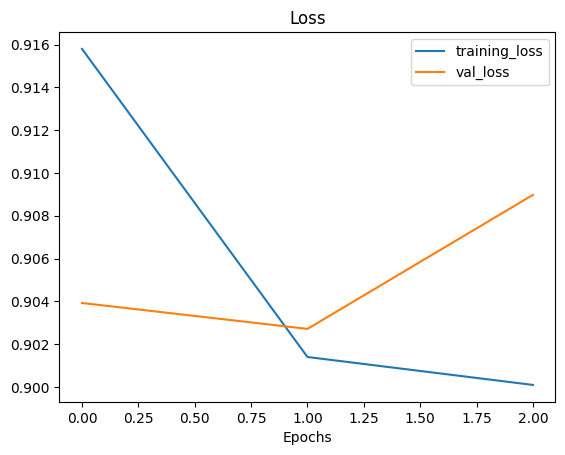

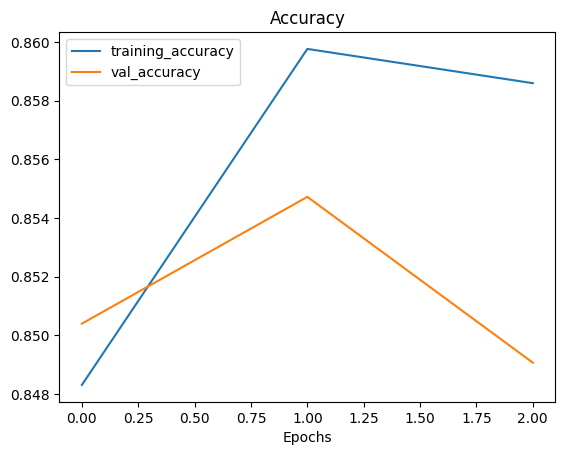

In [ ]:
plot_loss_curves(history_model_5)

In [ ]:
#Make predictions
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 23s 25ms/step


array([[0.5173531 , 0.08562229, 0.01574638, 0.35786113, 0.0234171 ],
       [0.5084018 , 0.11097908, 0.05845317, 0.30311304, 0.01905293],
       [0.2811949 , 0.09405878, 0.04543735, 0.53841007, 0.04089896],
       ...,
       [0.03050668, 0.10355256, 0.02602193, 0.0354964 , 0.80442244],
       [0.0281017 , 0.3393667 , 0.06568693, 0.02707281, 0.5397719 ],
       [0.07941534, 0.8550547 , 0.02131871, 0.02683049, 0.01738076]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.24758374155964,
 'precision': 0.8521942854768267,
 'recall': 0.8524758374155964,
 'f1': 0.851676364871283}

##Compare model results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.674037,0.783023,0.786740,0.784044
pretrained_token_embed,71.415332,0.714517,0.714153,0.711207
custom_char_embed_conv1d,44.747120,0.377355,0.447471,0.392743
hybrid_char_token_embed,73.110023,0.731423,0.731100,0.727623
tribrid_pos_char_token_embed,85.247584,0.852194,0.852476,0.851676


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

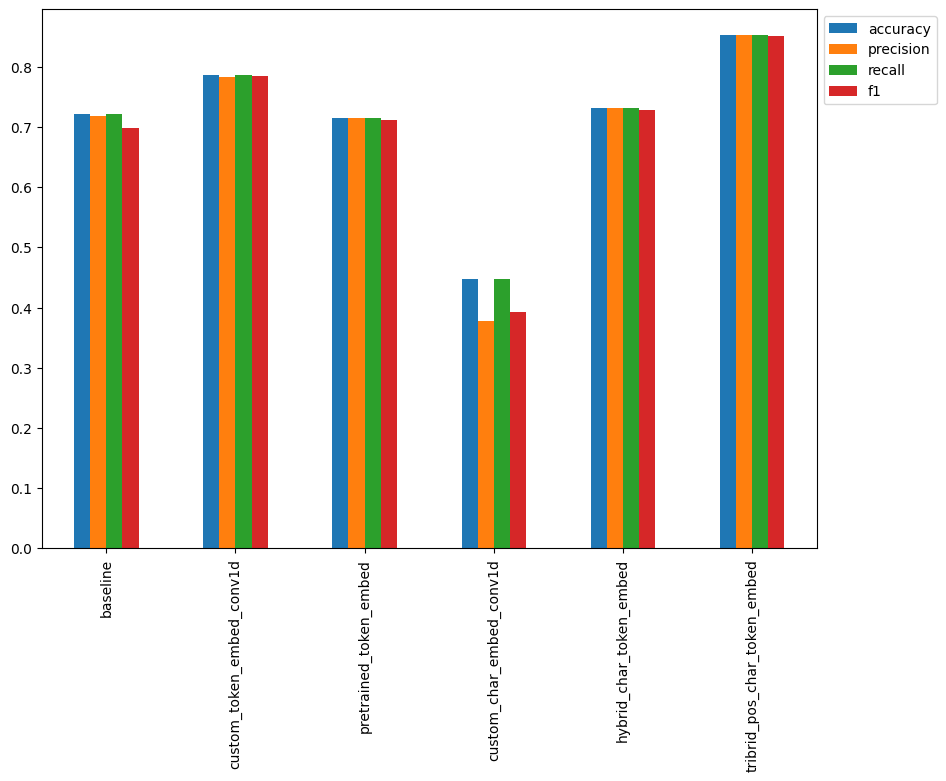

In [ ]:
all_model_results.plot(kind='bar',figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

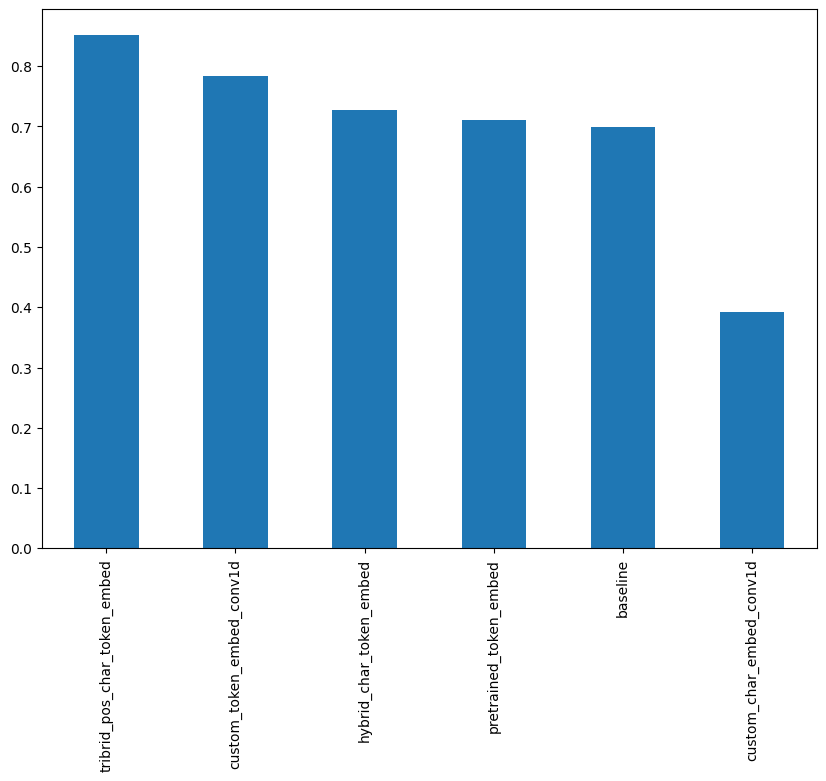

In [ ]:
#Sort models by f1-score
all_model_results.sort_values('f1',ascending=False)['f1'].plot(kind='bar',figsize=(10,7))

##Save and load model best performing model

In [ ]:
#Save best perforimg
model_5.save('skimlit_tribrid_model')

In [ ]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model


--2023-06-16 12:49:19--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 172.253.117.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  41.7MB/s    in 18s     

2023-06-16 12:49:37 (50.8 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/

In [ ]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#

In [ ]:
#Make predis on loaded model
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 23s 23ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.03323182841254,
 'precision': 0.8290556618130785,
 'recall': 0.8303323182841255,
 'f1': 0.8294263092000485}

In [ ]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([False, False, False, False])

##Evaluating model in test dataset

In [ ]:

# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]


942/942 [==============================] - 23s 24ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results



{'accuracy': 82.57176041148166,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

##Find most wrong

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 17.9 s, sys: 693 ms, total: 18.6 s
Wall time: 17.6 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS

In [ ]:

# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_numer,total_line,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.523885,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.351917,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.802459,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652782,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.665070,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.881815,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.529839,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.568003,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.461431,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.537819,True
